In [66]:
#imports and cwd
import numpy as np
from cv2 import cv2
import os
import matplotlib.pyplot as plt
import pickle
import scipy.optimize as opt
import scipy.stats as sts
import math
import vifida as vif

os.chdir("\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration")

In [67]:
#load calibration
cFile = open('M0.cal', 'rb')
[ieq,seq,signal2cresc,signal2decre,cresc2signal,decre2signal,model,sourcePositionVideo,sourceSpeedVideo] = pickle.load(cFile)
cFile.close()


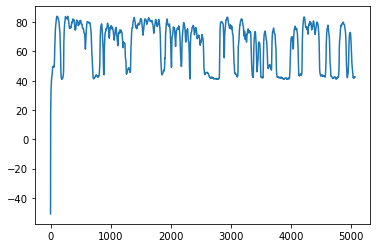

In [68]:
#Create a set of instructions from audio with the naive approach
slowFactor = 4
framerate = 25

wavfilepath = "\\\\DESKTOP-6VFOUOH\\Users\\GUR\\Code\\PoDA-M0\\Calibration\\sol.WAV"
#framerate*slowfactor accounts for the fact of recording at a lower speed
#it is only used here, from this point we work at the actual recording speed
sensed, samplerate, duration = vif.wavToSensed(wavfilepath,framerate*slowFactor,forceMono=True)

plt.plot(sensed)


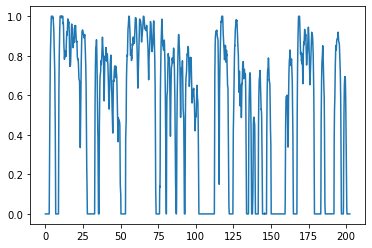

In [69]:
#adjust the variables to get nice dinamycs
drive = vif.sensedToFuzzy(sensed,thres=42,k=1.15)
time = np.linspace(0,len(drive)-1,len(drive),dtype="float64")/framerate

plt.plot(time,drive)

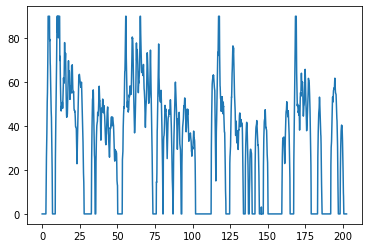

In [70]:
#visualise it angularly
ideal = signal2cresc(drive)*90

plt.plot(time,ideal)

Number of speeds unreachable:
153
Fraction unreachable:
0.0302


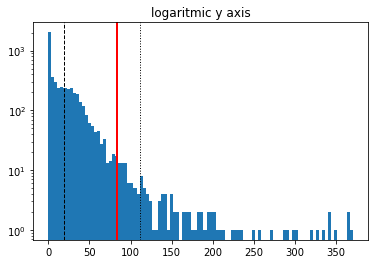

In [71]:
#study speed distributions
idealSpeeds=np.zeros( (len(ideal)-1,1) )

for i in range(len(idealSpeeds)):
    idealSpeeds[i]=(ideal[i+1]-ideal[i])*framerate

absIS=abs(idealSpeeds)

#compare to reachable speeds
absInputs=np.linspace(1,14,14)
absSpeeds=absInputs*ieq

plt.hist(absIS,bins = 100)
plt.axvline(absIS.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(absSpeeds.max(), color='red', linestyle='-', linewidth=2)
plt.axvline(absIS.mean()+3*absIS.std(), color='k', linestyle='dotted', linewidth=1)
plt.yscale('log')
plt.title("logaritmic y axis")

print("Number of speeds unreachable:")
print(sum(absIS>absSpeeds.max())[0])
print("Fraction unreachable:")
print(round((sum(absIS>absSpeeds.max())/len(absIS))[0],4))


Typical angular error:
2.4
Max angular error:
17.8


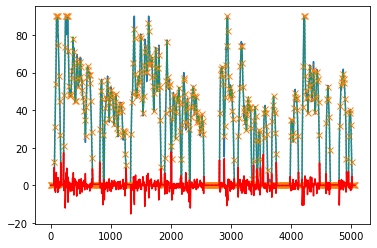

In [72]:
#fisrt approach: fixed number of movements N
N=460
orders=np.zeros((N+1,2))

#Inicialization
ind=np.linspace(0,len(ideal)-1,N+1,dtype='int')
controlIdeal=ideal[ind]
controlTime=time[ind]

for i in range(N):
    """ thisInd = ind[i]
    nextInd = ind[i+1]
    thisTime = (nextInd*1.0-thisInd*1.0)/framerate """
    thisTime = controlTime[i+1]-controlTime[i]

    #speed
    """ orders[i,0]=(ideal[nextInd]-ideal[thisInd])/thisTime """
    orders[i,0]=(controlIdeal[i+1]-controlIdeal[i])/thisTime
    orders[i,0]=round(orders[i,0]/ieq)
    if orders[i,0] > 14:
        orders[i,0] = 14
    elif orders[i,0] < -14:
        orders[i,0] = -14

    #steps
    if orders[i,0] == 0:
        orders[i,1]=round(thisTime*1000)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]
    else :
        orders[i,1]=abs(orders[i,0]*ieq)*thisTime
        orders[i,1]=round(orders[i,1]/seq)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]+math.copysign(orders[i,1],orders[i,0])*seq

#Reconstruction visualization:
rebuilt=np.zeros_like(ideal)
thisInd=0
for i in range(orders.shape[0]):
    thisI=orders[i,0]
    thisS=orders[i,1]
    if thisI==0:
        if thisS==0:
            break
        else: #if v==0, s are waiting time in ms
            nextInd= round(thisInd+thisS/1000*framerate).astype('int')
            interval=np.ones((nextInd-thisInd+1,1))*rebuilt[thisInd]
    else:
        thisTime= thisS*seq / (abs(thisI)*ieq)
        #print(thisTime)
        nextInd= thisInd + thisTime*framerate
        nextInd= round(nextInd).astype('int')
        interval=np.linspace(rebuilt[thisInd],
        rebuilt[thisInd]+math.copysign(thisS,thisI)*seq,
        nextInd-thisInd+1)
    
    rebuilt[thisInd:nextInd+1]=interval.flatten()
    thisInd=nextInd


plt.plot(ideal)
plt.plot(ind,ideal[ind],linestyle='',marker='x')
plt.plot(rebuilt,linestyle=':')
plt.plot(rebuilt-ideal,color='red')

print("Typical angular error:")
print(round(math.sqrt(np.mean(np.power((rebuilt-ideal),2))),1))
print("Max angular error:")
print(round(math.sqrt(np.max(np.power((rebuilt-ideal),2))),1))

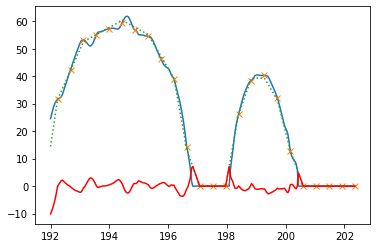

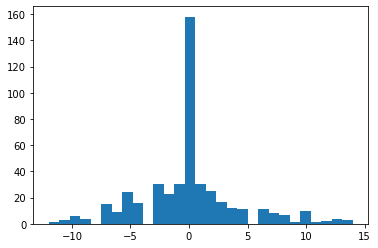

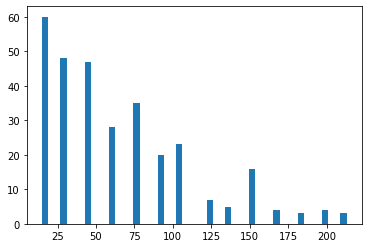

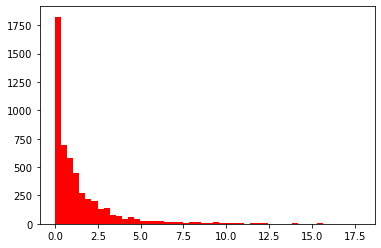

In [73]:
#zoom the first 20 seconds
aux1=4800
aux2=5060
plt.plot(time[aux1:aux2],ideal[aux1:aux2])
plt.plot(time[ind[ (ind>aux1)&(ind<aux2) ]],ideal[ind[ (ind>aux1)&(ind<aux2) ]],linestyle='',marker='x')
plt.plot(time[aux1:aux2],rebuilt[aux1:aux2],linestyle=':')
plt.plot(time[aux1:aux2],rebuilt[aux1:aux2]-ideal[aux1:aux2],color='red')
plt.show()

#velocity distribution
plt.hist(orders[:,0],bins=29)
plt.show()

#step number distribution
plt.hist(orders[orders[:,0]!=0,1],bins=50)
plt.show()

#error distribution
plt.hist(abs(rebuilt-ideal),bins=50,color='red')
plt.show()


In [74]:
#merge consecutive orders with same speed
extra=0
for i in range(N):
    if (orders[i+1,:]==np.array([0,0])).all():
        break

    thisO=orders[i,:]
    while orders[i+1,0]==thisO[0]:
        if orders[i+1,1]==0:
            break
        #merge
        orders[i,1]=orders[i,1]+orders[i+1,1]
        #send to back as (0,0)
        orders[i+1:-1,:]=orders[i+2:,:]
        extra=extra+1
        """ print("****************",i)
        print(extra) """


Typical angular error:
2.4
Max angular error:
17.8


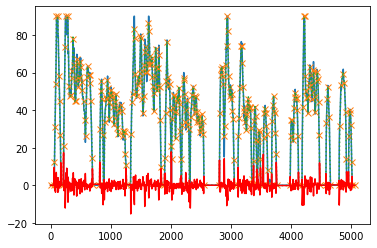

In [76]:
#Reconstruction after merge visualization:
rebuiltOld=rebuilt.copy()
rebuilt=np.zeros_like(ideal)
thisInd=0
ind=np.zeros((1,1),dtype=int)
for i in range(orders.shape[0]):
    thisI=orders[i,0]
    thisS=orders[i,1]
    if thisI==0:
        if thisS==0:
            break
        else: #if v==0, s are waiting time in ms
            nextInd= round(thisInd+thisS/1000*framerate).astype('int')
            interval=np.ones((nextInd-thisInd+1,1))*rebuilt[thisInd]
    else:
        thisTime= thisS*seq / (abs(thisI)*ieq)
        #print(thisTime)
        nextInd= thisInd + thisTime*framerate
        nextInd= round(nextInd).astype('int')
        interval=np.linspace(rebuilt[thisInd],
        rebuilt[thisInd]+math.copysign(thisS,thisI)*seq,
        nextInd-thisInd+1)
    
    ind=np.append(ind,nextInd)
    try:
        rebuilt[thisInd:nextInd+1]=interval.flatten()
    except:
        print(len(interval))
        if i==N-extra-1:
            rebuilt[thisInd:]=interval[:len(rebuilt[thisInd:])].flatten()
        else:
            print("SOMETHING IS WRONG")
    
    thisInd=nextInd

ind[N-extra]=len(ideal)-1
plt.plot(ideal)
plt.plot(ind,ideal[ind],linestyle='',marker='x')
plt.plot(rebuilt,linestyle=':')
plt.plot(rebuilt-ideal,color='red')

print("Typical angular error:")
print(round(math.sqrt(np.mean(np.power((rebuilt-ideal),2))),1))
print("Max angular error:")
print(round(math.sqrt(np.max(np.power((rebuilt-ideal),2))),1))

Typical angular error:
2.4
Max angular error:
17.8


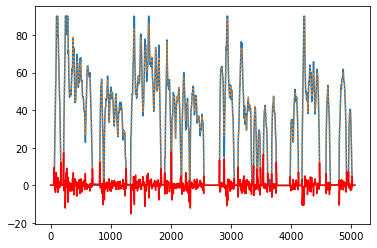

In [78]:
plt.plot(ideal)
plt.plot(rebuilt,linestyle=':')
plt.plot(rebuilt-ideal,color='red')

print("Typical angular error:")
print(round(math.sqrt(np.mean(np.power((rebuilt-ideal),2))),1))
print("Max angular error:")
print(round(math.sqrt(np.max(np.power((rebuilt-ideal),2))),1))

In [79]:
#Add extra control points in the points of maximum error
err=abs(ideal-rebuilt)
candidates=np.empty(0)
candInd=np.empty(0,dtype=int)
for i in range(N-extra): #maximum error point in each interval as candidate
    thisC=max(err[ ind[i]:ind[i+1] ])
    thisI=ind[i]+np.where(err[ ind[i]:ind[i+1] ]==thisC)[0][0]
    candidates=np.append(candidates,thisC)
    candInd=np.append(candInd,thisI)

newInd=candInd[np.argsort(-candidates)][:extra]
ind=np.sort(np.append(ind,newInd))

Typical angular error:
2.1
Max angular error:
17.0


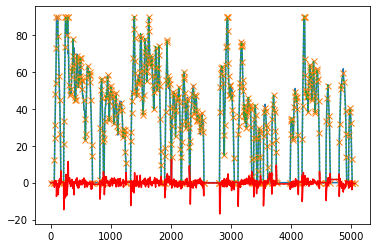

In [80]:
#calculate with the new control point selection
orders=np.zeros((N+1,2))

controlIdeal=ideal[ind]
controlTime=time[ind]

for i in range(N):
    thisTime = controlTime[i+1]-controlTime[i]

    #speed
    orders[i,0]=(controlIdeal[i+1]-controlIdeal[i])/thisTime
    orders[i,0]=round(orders[i,0]/ieq)
    if orders[i,0] > 14:
        orders[i,0] = 14
    elif orders[i,0] < -14:
        orders[i,0] = -14

    #steps
    if orders[i,0] == 0:
        orders[i,1]=round(thisTime*1000)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]
    else :
        orders[i,1]=abs(orders[i,0]*ieq)*thisTime
        orders[i,1]=round(orders[i,1]/seq)
        #update control point
        controlIdeal[i+1]=controlIdeal[i]+math.copysign(orders[i,1],orders[i,0])*seq

#Reconstruction visualization:
rebuilt=np.zeros_like(ideal)
thisInd=0
for i in range(orders.shape[0]):
    thisI=orders[i,0]
    thisS=orders[i,1]
    if thisI==0:
        if thisS==0:
            break
        else: #if v==0, s are waiting time in ms
            nextInd= round(thisInd+thisS/1000*framerate).astype('int')
            interval=np.ones((nextInd-thisInd+1,1))*rebuilt[thisInd]
    else:
        thisTime= thisS*seq / (abs(thisI)*ieq)
        #print(thisTime)
        nextInd= thisInd + thisTime*framerate
        nextInd= round(nextInd).astype('int')
        interval=np.linspace(rebuilt[thisInd],
        rebuilt[thisInd]+math.copysign(thisS,thisI)*seq,
        nextInd-thisInd+1)
    
    rebuilt[thisInd:nextInd+1]=interval.flatten()
    thisInd=nextInd


plt.plot(ideal)
plt.plot(ind,ideal[ind],linestyle='',marker='x')
plt.plot(rebuilt,linestyle=':')
plt.plot(rebuilt-ideal,color='red')

print("Typical angular error:")
print(round(math.sqrt(np.mean(np.power((rebuilt-ideal),2))),1))
print("Max angular error:")
print(round(math.sqrt(np.max(np.power((rebuilt-ideal),2))),1))

In [81]:
#Can we do it another time?
extra=0
for i in range(N):
    if (orders[i+1,:]==np.array([0,0])).all():
        break

    thisO=orders[i,:]
    while orders[i+1,0]==thisO[0]:
        if orders[i+1,1]==0:
            break
        #merge
        orders[i,1]=orders[i,1]+orders[i+1,1]
        #send to back as (0,0)
        orders[i+1:-1,:]=orders[i+2:,:]
        extra=extra+1
        """ print("****************",i)
        print(extra) """


In [86]:
extra       #so do it

41